# Comparison of memory usage of "web servers" in C++/Java/Rust




In [2]:
import shlex
from subprocess import Popen, PIPE
import time

def execute(cmd):
    """
    Executes the external command in a separate process and returns its pid immediately.
    """
    args = shlex.split(cmd)
    proc = Popen(args, stdout=PIPE, stderr=PIPE)
    return proc.pid

def measure(cmd):
    """
    Executes the external command returns its total wall-clock run time.
    """    
    args = shlex.split(cmd)
    times = []
    for i in range(0,3):
        start = time.time()
        proc = Popen(args, stdout=PIPE, stderr=PIPE)
        out, err = proc.communicate()
        exitcode = proc.returncode
        end = time.time()
        times.append(end-start)
    return sum(times) / len(times)


In [3]:
%matplotlib inline
import time
import math
import random
import pylab as plt
from IPython import display
import psutil
import itertools

def plot_time(cmd, params):
    """
    Executes command with one string parameter (%s) replaced by
    each of the given params and plots the execution time for each parameter
    """
    
    x = []
    y = []

    plt.xlabel("Load")
    plt.ylabel("Response Time")

    for param in params:
        x.append(param)
        y.append(measure(cmd % param))
        plt.plot(x,y,'ro')
        plt.axis([0, max(params)*1.2, 0, max(y) * 1.2])    
        display.clear_output(wait=True)
        plt.gcf().set_size_inches(15,8)
        display.display(plt.gcf())

    display.clear_output(wait=True)
    
def plot_mem(cmd):
    """
    Executes cmd and plots its memory usage over the first 10 seconds.
    """
    
    x = []
    y = []

    pid = execute(cmd)
    rss, vms = psutil.Process(pid).memory_info()
    plt.xlabel("Time")
    plt.ylabel("Memory Usage")

    for i in range(10):
        time.sleep(1.0)
        x.append(i)
        try:
            proc = psutil.Process(pid)
            rss, vms = proc.memory_info()
        except:
            break
        y.append(vms / 1000000)
        plt.plot(x,y,'ro')
        plt.axis([0, 10, 0, max(y) * 1.2])    
        display.clear_output(wait=True)
        plt.gcf().set_size_inches(15,8)
        display.display(plt.gcf())
        

    psutil.Process(pid).kill()
    display.clear_output(wait=True)

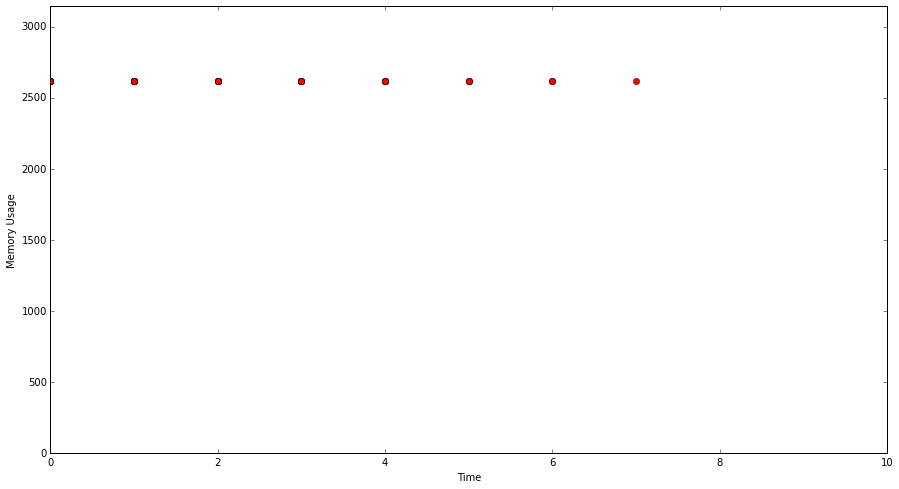

In [3]:
# C++ without memory leaks.
plot_mem("../c++/memory 200000 100 1")

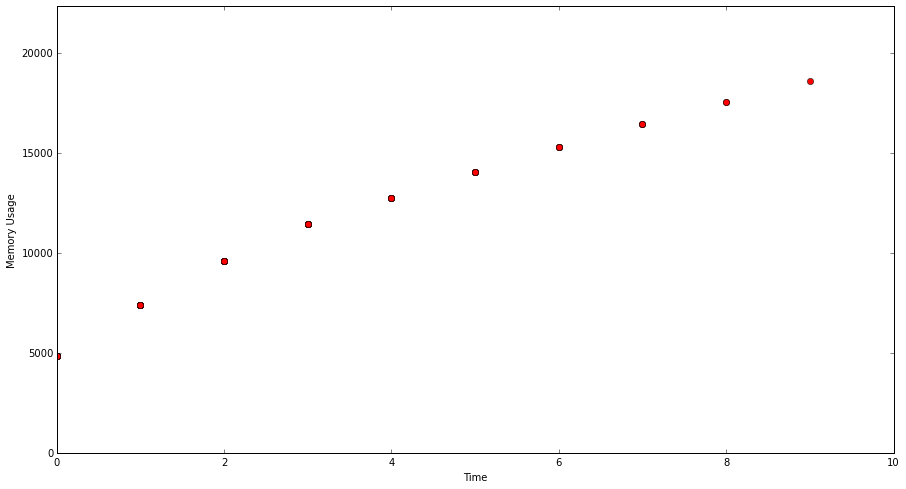

In [4]:
# C++ with memory leaks.
plot_mem("../c++/memory 200000 100 0")

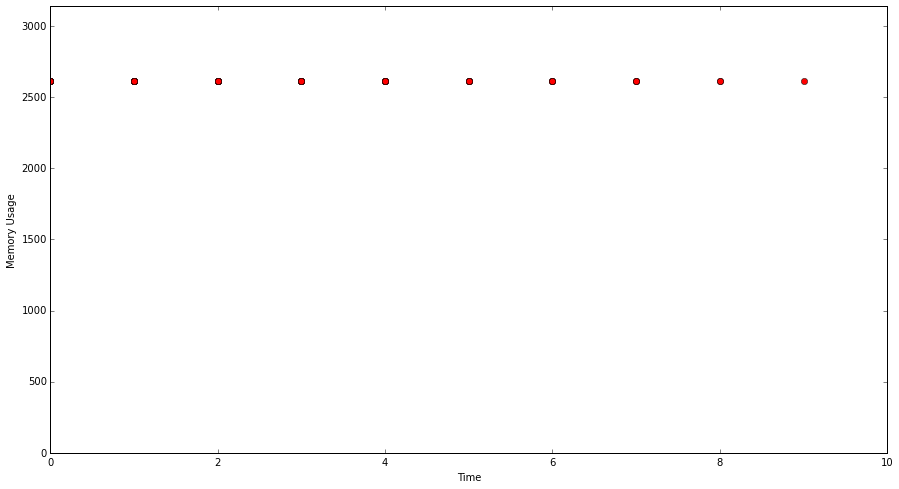

In [5]:
# Rust. Hopefully without memory leaks.
plot_mem("../rust/target/debug/memory -i 200000000 -b 100")

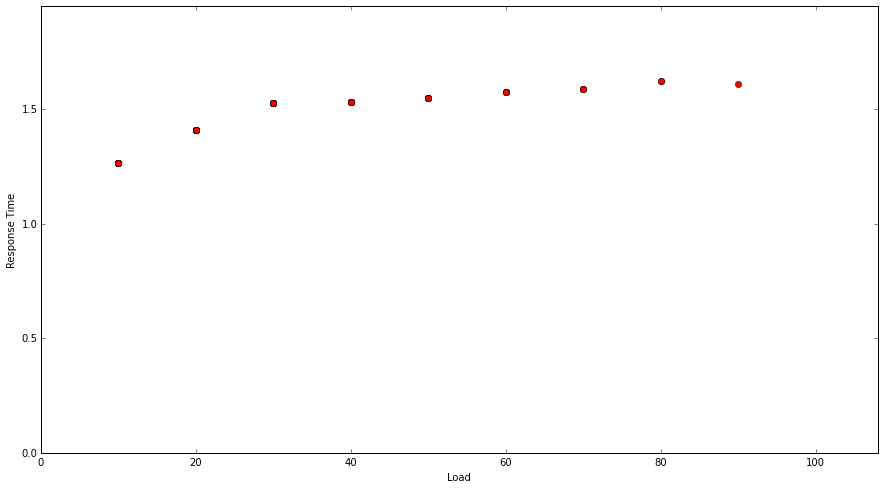

In [7]:
# C++ execution time without memory leaks.
cmd = "../c++/memory 30000 %s 1"
params = list(itertools.chain(range(10,100,10)))
plot_time(cmd, params)

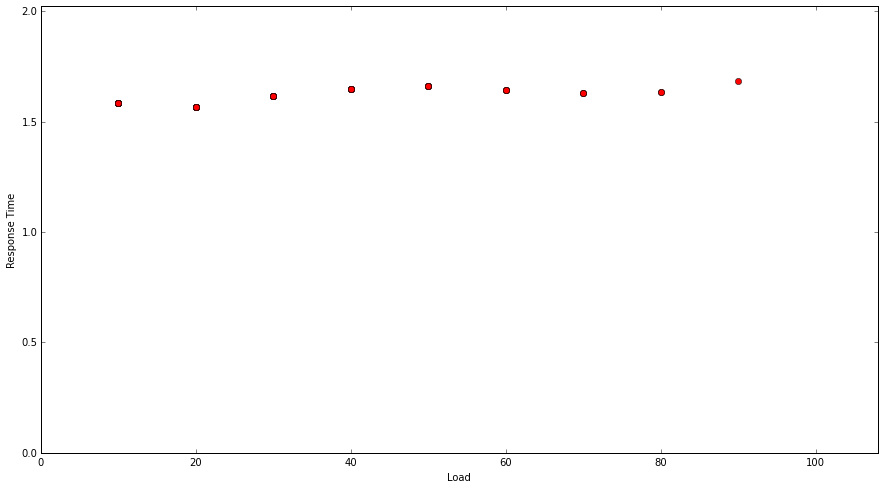

In [8]:
# C++ execution time with memory leaks.
cmd = "../c++/memory 3000 %s 0"
params = list(itertools.chain(range(10,100,10)))
plot_time(cmd, params)

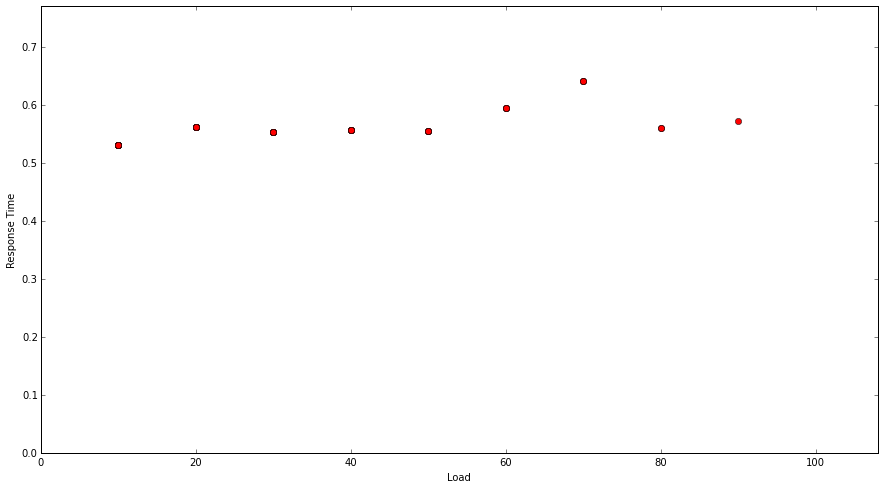

In [9]:
# Rust execution time.
cmd = "../rust/target/debug/memory -i 1000000 -b %s"
params = list(itertools.chain(range(10,100,10)))
plot_time(cmd, params)

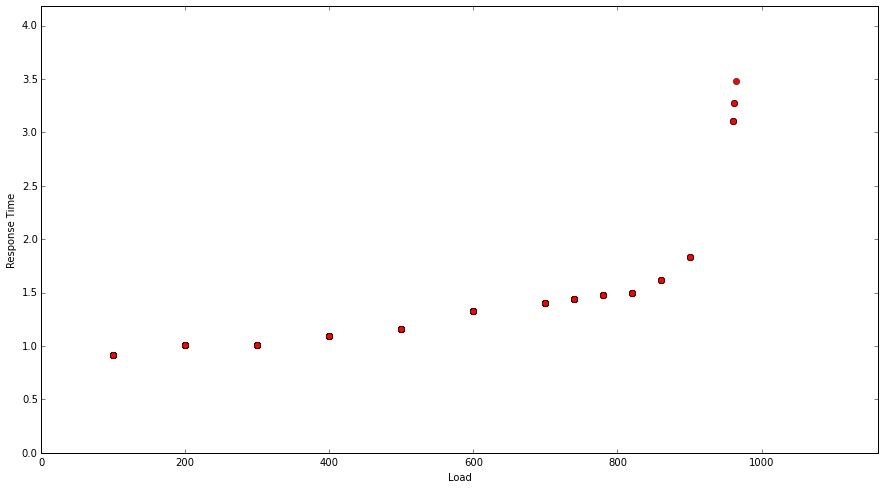

In [ ]:
# Java execution time.
cmd = "java -cp ../java/ -Xms1024m -Xmx1024m Memory 5000 %d"
params = list(itertools.chain(range(100,700,100), range(700,940,40), range(960,969,2)))
plot_time(cmd, params)